# Entrenamiento con reducción de dimensión con PCA
Atributos del tipo likert se tratan como categóricos ordinales, se aplica one-hot-encoding a los datos categóricos y se reduce la dimensión del conjunto por medio de PCA.  Posteriormente se entrena:

1. Un modelo por regresión logística
2. Un modelo por máquinas de soporte vectorial

En cada caso se selecciona un mejor modelo por validación cruzada.

Iniciamos por cargar la base de datos (se remueven aquellos renglones en los que hay valores desconocidos).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn  import metrics
import matplotlib.pyplot as plt

dF = pd.read_csv("prep_sales_data.csv").dropna()
dF.head(5)

,flag,gender,education,house_val,age,online,customer_psy,marriage,child,occupation,mortgage,house_owner,region,car_prob,fam_income
0,1,1,0.75,0.024869,6upto65,1,B,1,N,Professional,2Med,1,West,0.1,0.545455
1,0,1,0.75,0.041693,5upto55,1,C,1,Y,Professional,1Low,1,South,0.2,0.727273
2,1,1,0.75,0.024569,4upto45,0,F,1,U,Blue Collar,1Low,1,South,0.3,0.363636
3,1,1,0.50,0.036059,5upto55,1,C,1,Y,Professional,3High,1,Midwest,0.1,0.818182
4,1,0,0.00,0.016288,1_Unk,1,G,1,Y,Professional,1Low,0,South,0.7,0.181818


In [2]:
# Encoding
dF = pd.get_dummies(dF)

# Split in train and test sets
X, X_test, y, y_test =  train_test_split(dF.drop('flag', axis =1), dF['flag'], test_size=0.30, random_state=1)
X.head(5)

,gender,education,house_val,online,marriage,house_owner,car_prob,fam_income,age_1_Unk,age_2upto25,...,occupation_Retired,occupation_Sales/Service,mortgage_1Low,mortgage_2Med,mortgage_3High,region_Midwest,region_Northeast,region_Rest,region_South,region_West
4357,1,0.50,0.000000,0,1,1,0.8,0.545455,1,0,...,0,0,1,0,0,1,0,0,0,0
18641,0,1.00,0.019092,1,1,1,0.1,0.727273,0,0,...,0,0,1,0,0,1,0,0,0,0
8412,0,0.50,0.034999,0,1,1,0.1,0.454545,0,0,...,0,0,0,0,1,1,0,0,0,0
3882,0,1.00,0.000000,0,0,0,0.9,0.363636,0,0,...,0,0,1,0,0,0,1,0,0,0
5260,0,0.25,0.010251,0,0,1,0.9,0.000000,1,0,...,0,1,1,0,0,0,0,0,1,0


## PCA
Aplicamos Análisis de Componentes Principales (PCA), variando la proporción A de la varianza explicada.

In [3]:
# Import PCA and logistic regression modules, instantiate a model of logistic regression (cross validation folds = 10)
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
logistic_reg = LogisticRegressionCV(cv = 10, random_state = 1, max_iter = 150)

AUC_list = [np.inf]
Score_list = [np.inf]
As = np.linspace(0.6, 0.95, num=15)

for A in As:
    pca = PCA(A)
    # Apply pca to atributes matrix 
    pca.fit(X)
    var_ratios = pca.explained_variance_ratio_
    print("Para A =", A, "reducción de ", len(X.iloc[0]), " a ", len(var_ratios), "dimensiones")
    print("Varianza total explicada por las", len(var_ratios), "dimensiones conservadas:", var_ratios.sum()*100)

    # Reduced atributes matrix
    X_pca = pca.transform(X)
    # Train the model on X_pca
    logreg = logistic_reg.fit(X_pca, y)
    y_pred = logreg.predict(X_pca)
    AUC = metrics.roc_auc_score(y, y_pred)
    print("AUC:", AUC)
    AUC_list.append(AUC)
    Score_list.append(logreg.score(X_pca,y))

Para A = 0.6 reducción de  42  a  10 dimensiones
Varianza total explicada por las 10 dimensiones conservadas: 61.725087805403774
AUC: 0.67108075241724
Para A = 0.625 reducción de  42  a  11 dimensiones
Varianza total explicada por las 11 dimensiones conservadas: 65.27379625404524
AUC: 0.6737149161965879
Para A = 0.65 reducción de  42  a  11 dimensiones
Varianza total explicada por las 11 dimensiones conservadas: 65.27379625404524
AUC: 0.6737149161965879
Para A = 0.6749999999999999 reducción de  42  a  12 dimensiones
Varianza total explicada por las 12 dimensiones conservadas: 68.75495237190314
AUC: 0.6749662942896811
Para A = 0.7 reducción de  42  a  13 dimensiones
Varianza total explicada por las 13 dimensiones conservadas: 71.87296806725398
AUC: 0.6756652357606642
Para A = 0.725 reducción de  42  a  14 dimensiones
Varianza total explicada por las 14 dimensiones conservadas: 74.81003454445253
AUC: 0.6753671436699831
Para A = 0.75 reducción de  42  a  15 dimensiones
Varianza total expl

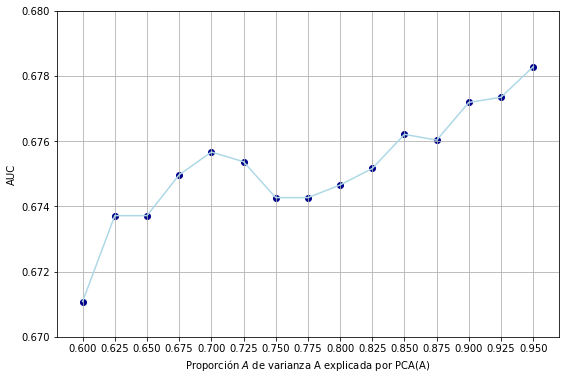

In [4]:
plt.figure(figsize=(9,6))
plt.plot(As, AUC_list[1:], color = 'lightblue')
plt.scatter(As, AUC_list[1:], color = 'darkblue')
#plt.plot(8, AUC_list[8], 'rx', markersize=12)
plt.xticks(As)
plt.ylim(0.67, 0.68)
plt.xlabel('Proporción $A$ de varianza A explicada por PCA(A)')
plt.ylabel('AUC')
plt.grid(True)
#plt.show()
plt.savefig('PCA.png')

In [5]:
# Best model, A = .90
pca = PCA(0.90)
pca.fit(X)

# Train the model on X_pca and y
X_pca = pca.transform(X)
best_logreg = logistic_reg.fit(X_pca, y)

# Evaluate on X_test y y_test
X_test_pca = pca.transform(X_test)
y_test_pred = best_logreg.predict(X_test_pca) 

# Details of the model
print("Coeficientes del modelo: \n", best_logreg.coef_)
print("Score sobre el conjunto de entrenamiento:", best_logreg.score(X_pca,y))
print("Score sobre el conjunto de validación:", best_logreg.score(X_test_pca, y_test))

# Quality of the model
print("Cualidades de la clasificación:\n", classification_report(y_test, y_test_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_test_pred, labels = range(2)) )

Coeficientes del modelo: 
 [[-1.06399434  0.02544444 -0.1688154   0.39693021  0.13206901  0.30264544
   0.10608891  0.13941075 -0.65007852  0.36246398 -0.27505598 -0.46806756
   0.35820555  0.02045747 -0.19203573  0.0496527   0.04356277  0.10137488
  -0.02021107  0.24200307  0.28283126]]
Score sobre el conjunto de entrenamiento: 0.6905397210430564
Score sobre el conjunto de validación: 0.7007640067911715
Cualidades de la clasificación:
               precision    recall  f1-score   support

           0       0.68      0.59      0.63      3105
           1       0.71      0.79      0.75      3963

   micro avg       0.70      0.70      0.70      7068
   macro avg       0.70      0.69      0.69      7068
weighted avg       0.70      0.70      0.70      7068

Matriz de confusión:
 [[1833 1272]
 [ 843 3120]]


# Máquinas de soporte vectorial (SVM)
Con X_pca y y_pca obtenemos un modelo por SVMs. En la selección del modelo evaluamos modelos con diferentes coeficientes de regularización C y gama, y evaluamos con 5fold cross validation

In [8]:
# SLOW!!!
# Import scikit-learn modules
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Split the data
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.30, random_state=1)

# SLOW!!!
# Find best SVM model through 5fold cv and grid search, radial kernel
grid = {'C': [1, 10, 100], 'gamma': [0.01, 0.05, 0.1], } #{'C': [1, 10, 100], 'gamma': [0.005, 0.01, 0.1], }
svm_model = GridSearchCV(SVC(kernel='rbf'), grid, cv=5, iid=False)

svm_model = svm_model.fit(X_pca_train, y_pca_train)

In [12]:
print("Mejor modelo SVM encontrado por grid search:")
print(svm_model.best_estimator_)

# Quality of the model
print("Score sobre el conjunto de entrenamiento:", svm_model.score(X_pca_train, y_pca_train))
print("Score sobre el conjunto de validación:", svm_model.score(X_pca_test, y_pca_test))
y_pca_test_pred = svm_model.predict(X_pca_test)
print("Cualidades de la clasificación:\n", classification_report(y_pca_test, y_pca_test_pred))
print("Matriz de confusión:\n", confusion_matrix(y_pca_test, y_pca_test_pred,labels = range(2)) )

Mejor modelo SVM encontrado por grid search:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Score sobre el conjunto de entrenamiento: 0.7122931646885559
Score sobre el conjunto de validación: 0.6895087932080048
Cualidades de la clasificación:
               precision    recall  f1-score   support

           0       0.69      0.52      0.59      2133
           1       0.69      0.82      0.75      2814

   micro avg       0.69      0.69      0.69      4947
   macro avg       0.69      0.67      0.67      4947
weighted avg       0.69      0.69      0.68      4947

Matriz de confusión:
 [[1102 1031]
 [ 505 2309]]
